# Tutorial 8: Diff_Tech_MOSTA_integration
This tutorial primarily describes the process of using samples seqFISH(E8.5) and Stereo-seq(E10.5) to interpolate the intermediate data.

## Environment Configuration & Package Loading

In [1]:
import os
import torch
import scanpy as sc
from GenOT import genot
import warnings

warnings.filterwarnings("ignore")


C:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1'
os.environ['PATH'] = 'C:/Program Files/R/R-4.4.1/bin/x64;' + os.environ['PATH']

## Data Loading

In [3]:
adata1 = sc.read_h5ad(r"..\Data\seqFISH(embryo1).h5ad")
adata1 = sc.pp.subsample(adata1, n_obs=5000, random_state=0, copy=True)
adata2 = sc.read_h5ad(r'..\Data\E10.5_E2S1.MOSTA.h5ad')
adata2 = sc.pp.subsample(adata2, n_obs=5000, random_state=0, copy=True)

In [4]:
adata1

AnnData object with n_obs × n_vars = 5000 × 351
    obs: 'x_global', 'y_global'
    obsm: 'spatial'

## normalize

In [5]:
from GenOT.utils import normalize_sparse

adata1 = normalize_sparse(adata1)
adata2 = normalize_sparse(adata2)


## Align the input datasets adata1 and adata2 using the GenOT algorithm.

In [6]:
from GenOT.utils import align_spatial_coords
from GenOT.plotting import visualize_alignment

adata2.obsm['spatial'] = align_spatial_coords(adata1.obsm['spatial'], adata2.obsm['spatial'])

## Data Preprocessing

In [7]:

from GenOT.utils import get_unique_marker_genes

unique_marker_genes = get_unique_marker_genes(adata2, annotation_column_name='annotation', n_top_genes=500)

common_genes = set(unique_marker_genes) & set(adata1.var_names) & set(adata2.var_names)
matching_genes = list(common_genes)

adata1 = adata1[:, matching_genes].copy()
adata2 = adata2[:, matching_genes].copy()


Using annotation column 'annotation' for marker gene analysis...
Unique values in annotation column: ['Mucosal epithelium', 'Cavity', 'Jaw and tooth', 'Spinal cord', 'Dermomyotome', 'Mesenchyme', 'Urogenital ridge', 'Dorsal root ganglion', 'Lung primordium', 'Blood vessel', 'Heart', 'Brain', 'Liver', 'Connective tissue', 'Sclerotome', 'Head mesenchyme', 'Notochord', 'Choroid plexus']
Extracted 2725 unique marker genes from the top 500 genes per annotation group.
First 10 extracted marker genes: ['0610009B22Rik', '0610010K14Rik', '1110004F10Rik', '1110008F13Rik', '1110059E24Rik', '1500011K16Rik', '1700007G11Rik', '1700016D06Rik', '1700020I14Rik', '1700030K09Rik']...


## Run GenOT

In [8]:
# define model
Encoder = genot.DualEncoder(adata1, adata2, device=device, pca_n=16)


In [9]:
adata1, adata2 = Encoder.train_encoder()


Training DualEncoder on 2 datasets with 700 epochs...


Training: 100%|██████████| 700/700 [00:22<00:00, 31.73it/s]

Training completed!


 Compute the spatial barycenter

In [10]:
from GenOT.OTutils import compute_spatial_barycenter, compute_emb_barycenter

Xb_s, s_transport_plans = compute_spatial_barycenter(adata1, adata2, weight1=0.5, num_barycenters=5000)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.314898e+06|0.000000e+00|0.000000e+00
    1|2.314771e+06|5.462569e-05|1.264460e+02
    2|2.314771e+06|3.425678e-08|7.929660e-02
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|2.294781e+06|0.000000e+00|0.000000e+00
    1|2.294662e+06|5.172006e-05|1.186801e+02
    2|2.294662e+06|0.000000e+00|0.000000e+00
It.  |Err         
-------------------
    0|4.675275e+05|
    0|1.516650e+05|
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|6.572961e+03|0.000000e+00|0.000000e+00
    1|1.024273e+02|6.317195e+01|6.470533e+03
    2|8.603164e+01|1.905772e-01|1.639567e+01
    3|8.491370e+01|1.316568e-02|1.117946e+00
    4|8.491370e+01|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|6.088309e+03|0.000000e+00|0.000000e+

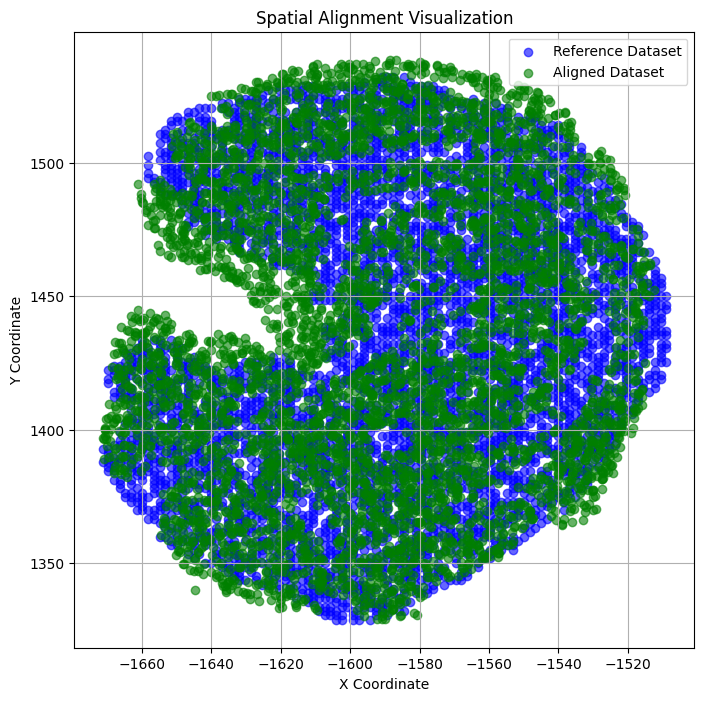

In [11]:
visualize_alignment(adata2.obsm['spatial'], Xb_s)

In [12]:
decoder = genot.Decoder(
    input_size=adata1.obsm['emb'].shape[1],  # Input dimension
    output_size=adata1.X.shape[1],  # Output dimension
)
# Train the decoder
trained_decoder = decoder.train_decoder(adata1, adata2, decoder, epochs=500, batch_size=2048)

100%|██████████| 500/500 [00:42<00:00, 11.90it/s]


In [13]:
embd0 = adata1.obsm['emb']
embd1 = adata2.obsm['emb']

## Compute the embedding barycenter for the latent representations.

In [14]:
Xb, e_transport_plans = compute_emb_barycenter(adata1, adata2, weight1=0.5, num_barycenters=5000, alpha=0)

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.208798e+01|0.000000e+00|0.000000e+00
    1|3.749976e+01|3.890219e-01|1.458823e+01
    2|3.749976e+01|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|3.425884e+01|0.000000e+00|0.000000e+00
    1|2.013684e+01|7.013015e-01|1.412200e+01
    2|2.013684e+01|0.000000e+00|0.000000e+00
It.  |Err         
-------------------
    0|9.931621e+03|
    0|3.476126e+02|
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.635861e+01|0.000000e+00|0.000000e+00
    1|5.092606e+00|2.212227e+00|1.126600e+01
    2|5.092606e+00|0.000000e+00|0.000000e+00
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.511027e+01|0.000000e+00|0.000000e+00
    1|5.145836e+00|1.936407e+00|9.964434e+00
    2|5.145836e+00|0.000000e+00|0.000000e+

Since the spatial barycenter and embedding barycenter reside in different spaces (not one-to-one cell correspondences), we align them by constraining the embedding barycenter. Refer to the [update_embedding_barycenter] function for details.

In [15]:

from GenOT.OTutils import update_embedding_barycenter

Xb = update_embedding_barycenter(Xb_s, Xb, s_transport_plans, e_transport_plans)


## Use the trained decoder to transform the embedding barycenter into gene expression values.

In [16]:
new_embedding = torch.tensor(Xb, dtype=torch.float32)
new_embedding = new_embedding.to("cuda" if torch.cuda.is_available() else "cpu")

trained_decoder.eval()
with torch.no_grad():
    reconstructed_features = trained_decoder(new_embedding)

reconstructed_gene_expression = reconstructed_features.cpu().numpy()

print("Reconstructed Features Shape:", reconstructed_gene_expression.shape)


Reconstructed Features Shape: (5000, 41)


Create a new adata object where the gene expression matrix equals the generated expression values, and spatial coordinates match the spatial barycenter.

In [17]:
new_adata = adata1.copy()
X = reconstructed_gene_expression.copy()
thresholds = X.max(axis=0) / 3
for i, threshold in enumerate(thresholds):
    X[:, i][X[:, i] < threshold] = 0
new_adata.X = X
new_adata.obsm['spatial'] = Xb_s

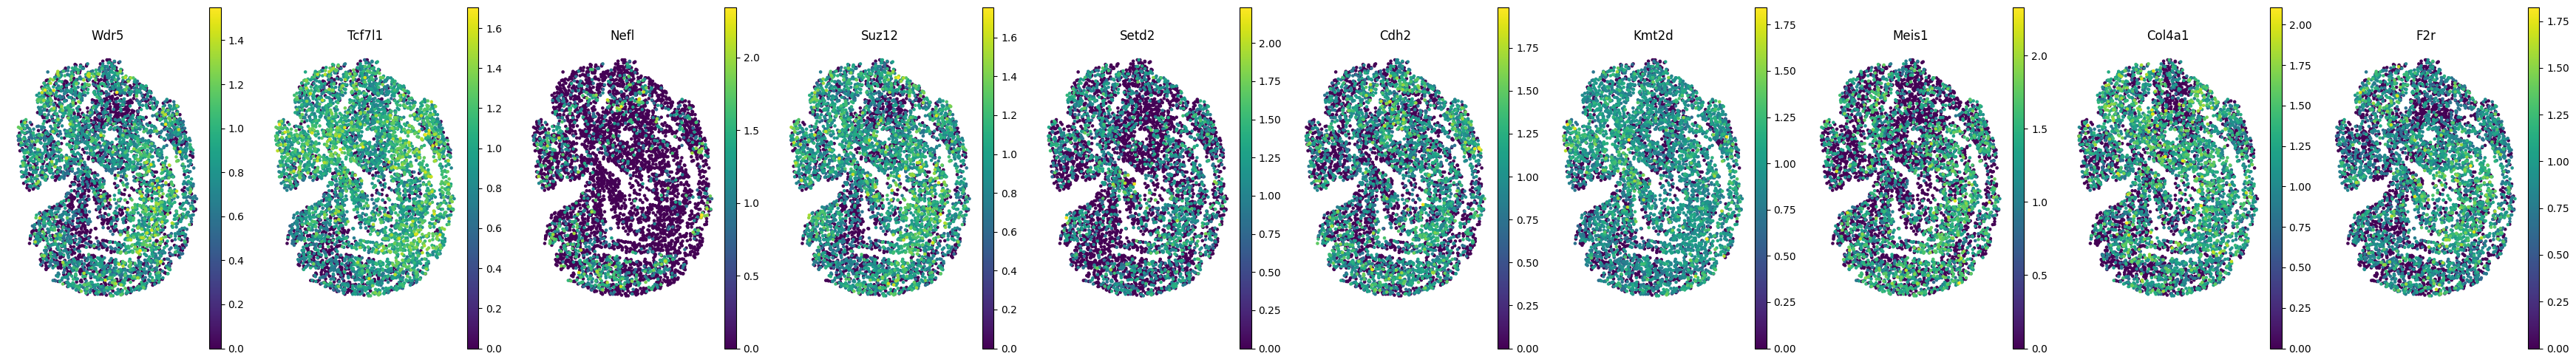

In [18]:
import matplotlib.pyplot as plt
import scanpy as sc

common_genes = adata1.var_names
genes_of_interest = list(common_genes)[10:20]

fig, axes = plt.subplots(1, 10, figsize=(35, 5))
plt.subplots_adjust(wspace=0.3)

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(
        new_adata,
        color=gene,
        ax=axes[i],
        title=gene,
        show=False,
        size=1.5,
        spot_size=2,
        cmap='viridis',
        frameon=False
    )

plt.tight_layout()
plt.show()




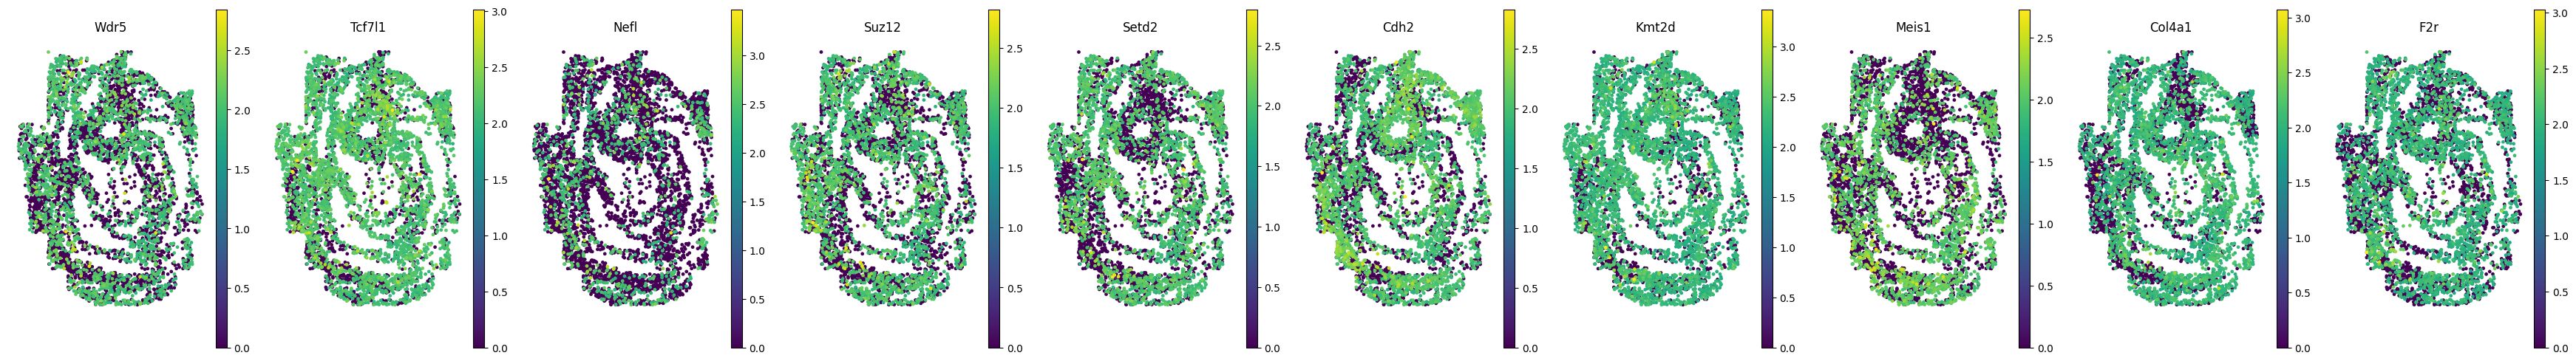

In [19]:
common_genes = adata1.var_names
genes_of_interest = list(common_genes)[10:20]

fig, axes = plt.subplots(1, 10, figsize=(35, 5))
plt.subplots_adjust(wspace=0.3)

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(
        adata1,
        color=gene,
        ax=axes[i],
        title=gene,
        show=False,
        size=1.5,
        spot_size=2,
        cmap='viridis',
        frameon=False
    )

plt.tight_layout()
plt.show()

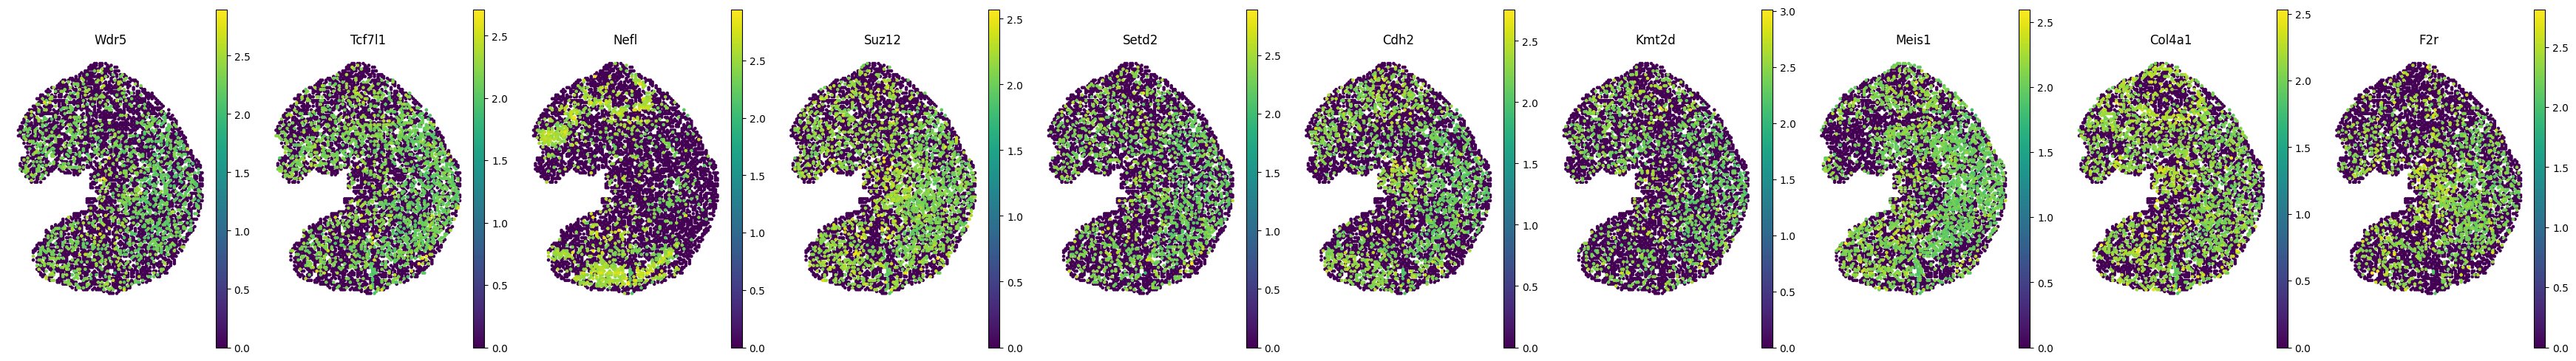

In [20]:
common_genes = adata1.var_names
genes_of_interest = list(common_genes)[10:20]

fig, axes = plt.subplots(1, 10, figsize=(35, 5))
plt.subplots_adjust(wspace=0.3)

for i, gene in enumerate(genes_of_interest):
    sc.pl.spatial(
        adata2,
        color=gene,
        ax=axes[i],
        show=False,
        size=1.5,
        spot_size=2,
        cmap='viridis',
        frameon=False
    )

plt.tight_layout()
plt.show()

## Visualize the Col1a1 gene expression across datasets.

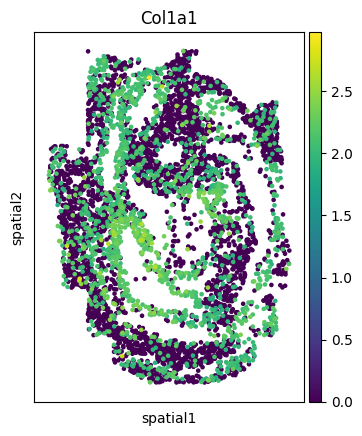

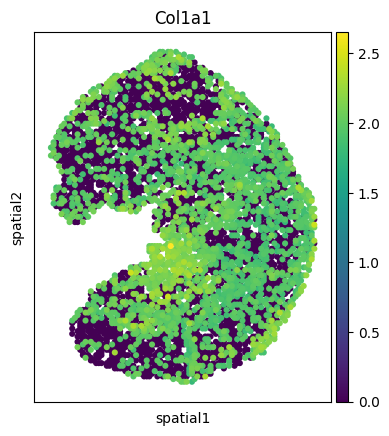

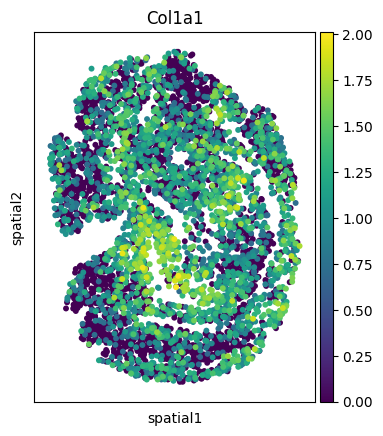

In [21]:
sc.pl.spatial(adata1, img_key=None, color='Col1a1', cmap='viridis', size=2, spot_size=1.5)
sc.pl.spatial(adata2, img_key=None, color='Col1a1', cmap='viridis', size=2.5, spot_size=1.5)
sc.pl.spatial(new_adata, img_key=None, color='Col1a1', cmap='viridis', size=2.5, spot_size=1.5)